In [6]:
import pandas as pd
import numpy as np
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Descriptive Statistics of Features:                        count          mean           std         min  \
p_t                  15832.0      0.022487      0.017872    0.000000   
lexical_spike_delta  15832.0      0.000328      0.017872   -0.022159   
perplexity           15832.0    513.777110    405.422744    0.000000   
burstiness           15832.0      0.666201      0.450737    0.000000   
mean_dep_depth       15832.0      3.612440      0.798653    0.000000   
clause_ratio         15832.0      0.844290      0.558929    0.000000   
voice_ratio          15832.0      0.989009      0.016739    0.000000   
fre                  15832.0     28.797081     19.939399 -226.728904   
fog                  15832.0     17.110452      4.805757    0.000000   
chars_per_sent       15832.0    193.880272    103.234973    0.000000   
sents_per_para       15832.0    137.503916    177.397141    0.000000   
nTTR                 15832.0      7.015387      0.825452    0.000000   
word_density         15832.0

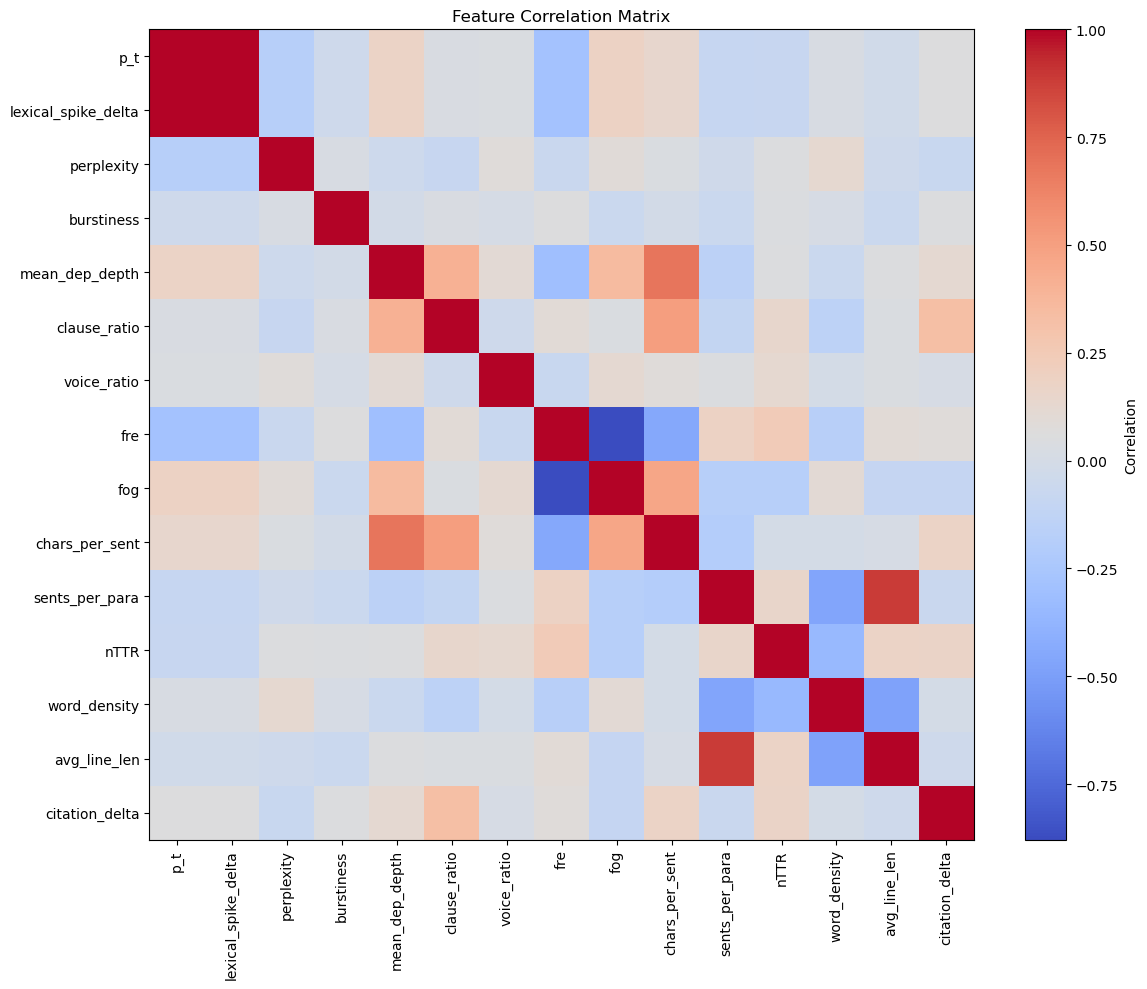

Principal Component Loadings:                           PC1       PC2       PC3       PC4       PC5
p_t                 -0.309918  0.127222  0.484984 -0.316772  0.129571
lexical_spike_delta -0.309918  0.127222  0.484984 -0.316772  0.129571
perplexity           0.014827 -0.105241 -0.158524  0.298169  0.412250
burstiness           0.022038 -0.040127 -0.109952 -0.110589  0.252703
mean_dep_depth      -0.335777  0.278200 -0.248187  0.006569 -0.065139
clause_ratio        -0.147402  0.284466 -0.394350 -0.277704 -0.169887
voice_ratio         -0.058497  0.084419 -0.015727  0.132414  0.683272
fre                  0.426266  0.014010 -0.105529 -0.380257  0.014410
fog                 -0.414356  0.021417  0.008267  0.405687 -0.005354
chars_per_sent      -0.385225  0.249226 -0.309203  0.069344 -0.091698
sents_per_para       0.281886  0.419059  0.225136  0.254963 -0.070236
nTTR                 0.142227  0.277074 -0.174378 -0.135533  0.448798
word_density        -0.163441 -0.452402 -0.043576 -0.034260 

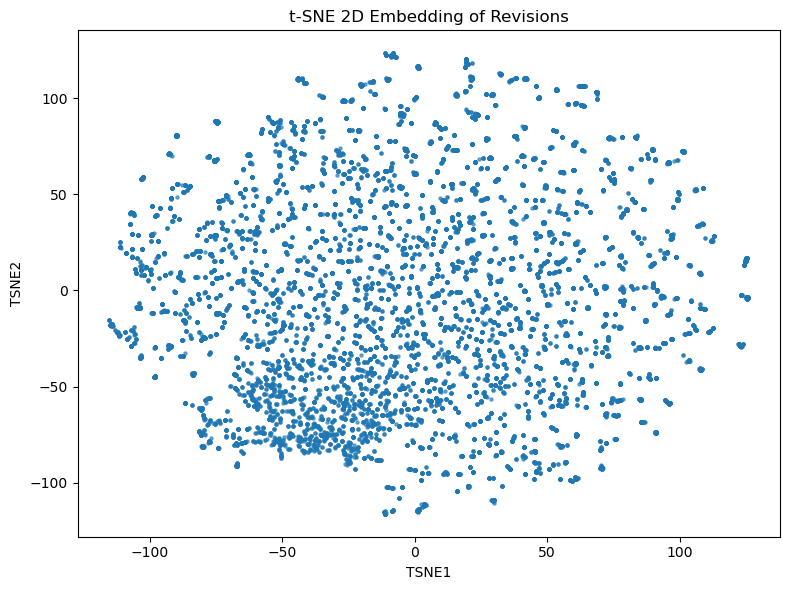

In [16]:
from sklearn.impute import SimpleImputer

# 2. Load the revision-level DataFrame (update path as needed)
df = pd.read_csv('../python_code/everything100percat.csv')

# 3. Identify numeric feature columns (excluding metadata/int identifiers)
meta_cols = ['Unnamed: 0', 'snapshot_ts', 'rev_id', 'timestamp', 'user',
             'is_bot', 'content', 'article_id', 'title', 'root', 'stratum', 'plain_text']
feature_cols = [c for c in df.columns if df[c].dtype in [np.float64, np.int64] and c not in meta_cols]

# 1. Descriptive statistics (impute for completeness)
imputer = SimpleImputer(strategy='median')
X_imp = imputer.fit_transform(df[feature_cols])
df_imp = pd.DataFrame(X_imp, columns=feature_cols)

desc_stats = df_imp.describe().T
print("Descriptive Statistics of Features:", desc_stats)

print(desc_stats)

# 5. Correlation heatmap of features
corr = df[feature_cols].corr()
plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation')
plt.xticks(range(len(feature_cols)), feature_cols, rotation=90)
plt.yticks(range(len(feature_cols)), feature_cols)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# 6. PCA for dimensionality reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imp)

pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)
loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_cols,
    columns=[f'PC{i + 1}' for i in range(5)]
)
explained_var = pd.Series(
    pca.explained_variance_ratio_,
    index=[f'PC{i + 1}' for i in range(5)]
)

print("Principal Component Loadings:", loadings)

print("Explained Variance Ratio by PCA Components:", explained_var)

# 7. t-SNE embedding for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])

print("first 1000 points of t-SNE embedding:")
print(df_tsne.head(1000))

plt.figure(figsize=(8, 6))
plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], s=5, alpha=0.6)
plt.title('t-SNE 2D Embedding of Revisions')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.tight_layout()
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_32624\2413387593.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


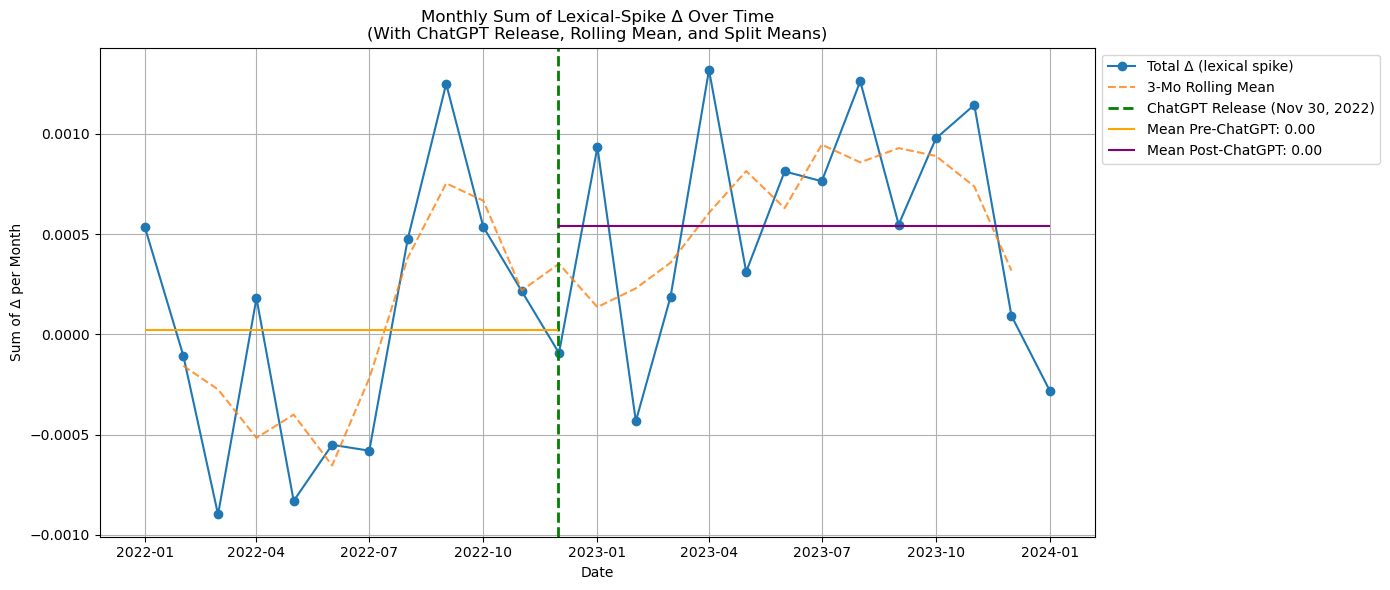

In [26]:
# 1. Read in your CSV
df = pd.read_csv(
    '../python_code/everything100percat.csv',
    parse_dates=['snapshot_ts'],
    date_parser=lambda s: pd.to_datetime(s).tz_convert(None)  # drop tz if present
)

# 2. Bucket into calendar-month Timestamps correctly
df['month'] = (
    df['snapshot_ts']
      .dt.tz_localize(None)           # drop any tz info
      .dt.to_period('M')              # convert to monthly period
      .dt.to_timestamp()              # back to Timestamp at period start
)

# 3. Aggregate your delta by month
monthly = (
    df.groupby('month')['lexical_spike_delta']
      .mean()
      .reset_index(name='total_delta')
)

# 4. Rolling mean and split means
monthly['rolling_mean'] = monthly['total_delta'].rolling(3, center=True).mean()
release      = pd.Timestamp('2022-11-30')
mean_pre     = monthly.loc[monthly['month'] <= release, 'total_delta'].mean()
mean_post    = monthly.loc[monthly['month']  > release, 'total_delta'].mean()

# 5. Plot with segmented horizontal lines
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(monthly['month'], monthly['total_delta'],
        marker='o', label='Total Δ (lexical spike)')
ax.plot(monthly['month'], monthly['rolling_mean'],
        linestyle='--', label='3-Mo Rolling Mean', alpha=0.8)
ax.axvline(release, color='green', linestyle='--', linewidth=2,
           label='ChatGPT Release (Nov 30, 2022)')

ax.hlines(mean_pre,
          xmin=monthly['month'].min(),
          xmax=release,
          colors='orange',
          linestyles='-',
          linewidth=1.5,
          label=f'Mean Pre-ChatGPT: {mean_pre:.2f}')
ax.hlines(mean_post,
          xmin=release,
          xmax=monthly['month'].max(),
          colors='purple',
          linestyles='-',
          linewidth=1.5,
          label=f'Mean Post-ChatGPT: {mean_post:.2f}')

ax.set_title('Monthly Sum of Lexical-Spike Δ Over Time\n'
             '(With ChatGPT Release, Rolling Mean, and Split Means)')
ax.set_xlabel('Date')
ax.set_ylabel('Sum of Δ per Month')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.grid(True)
fig.tight_layout()
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_32624\43643981.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


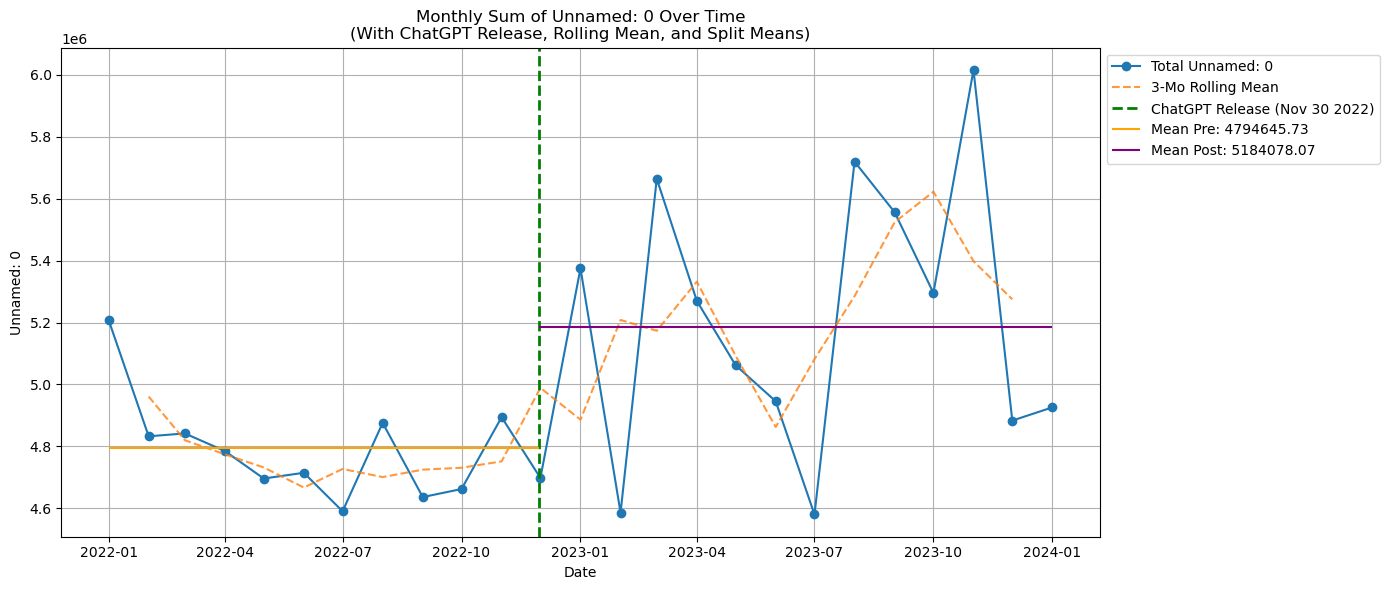

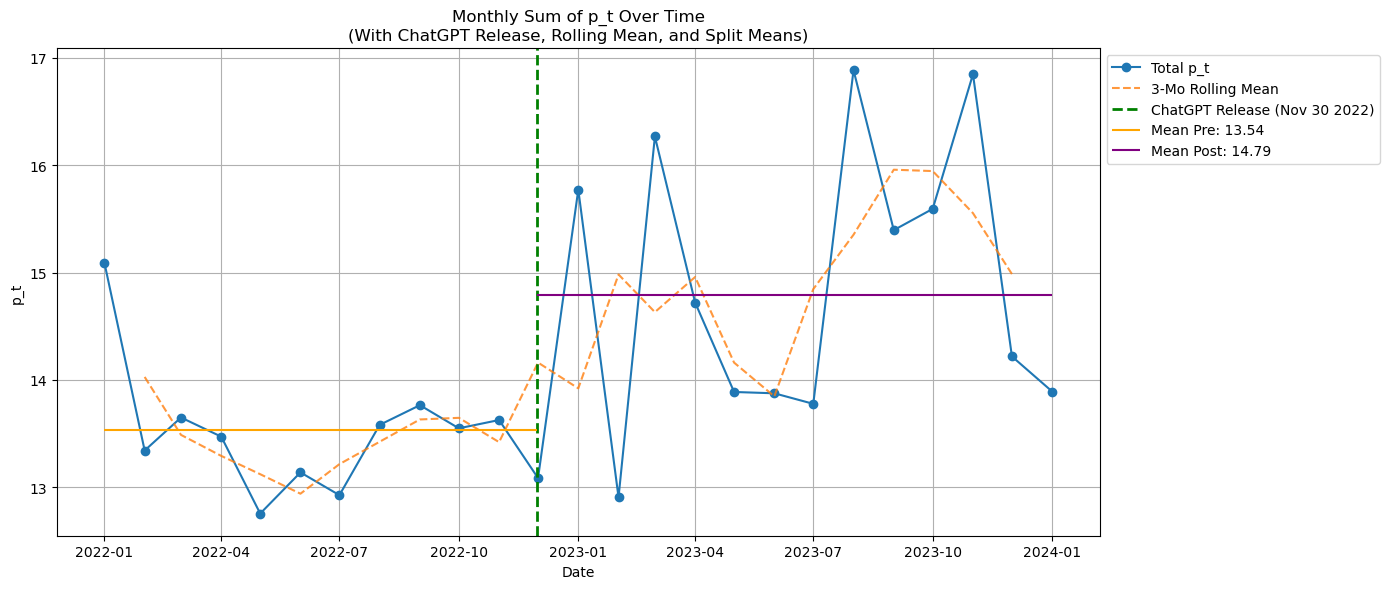

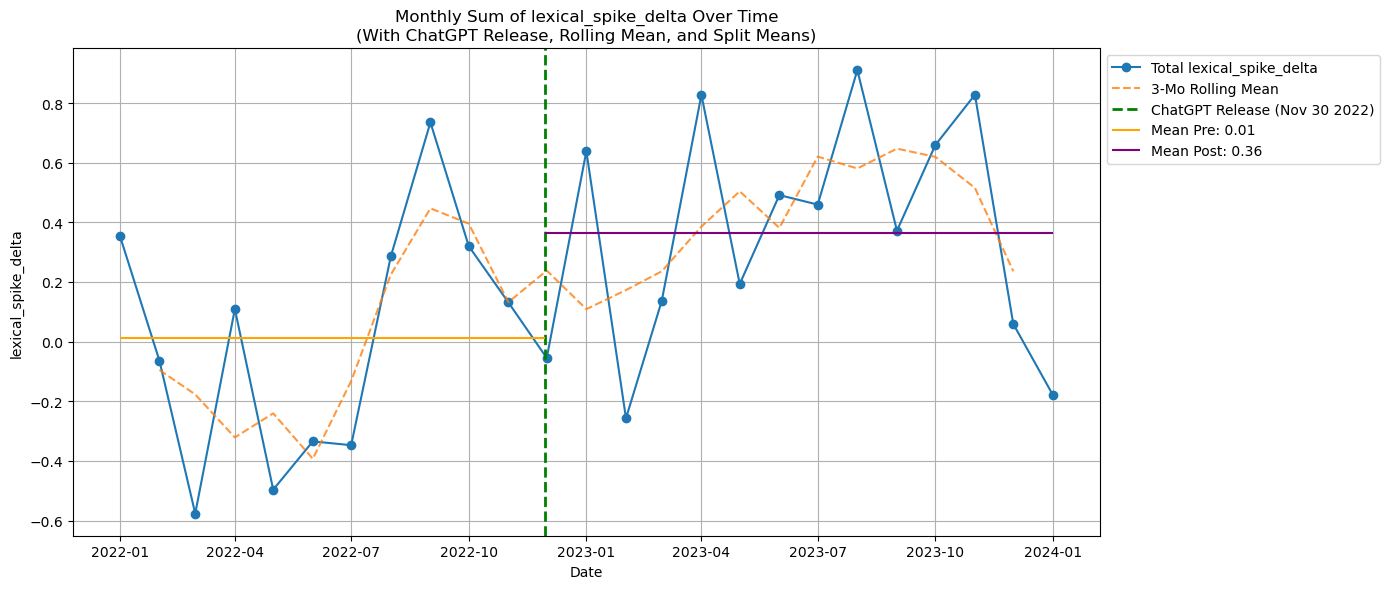

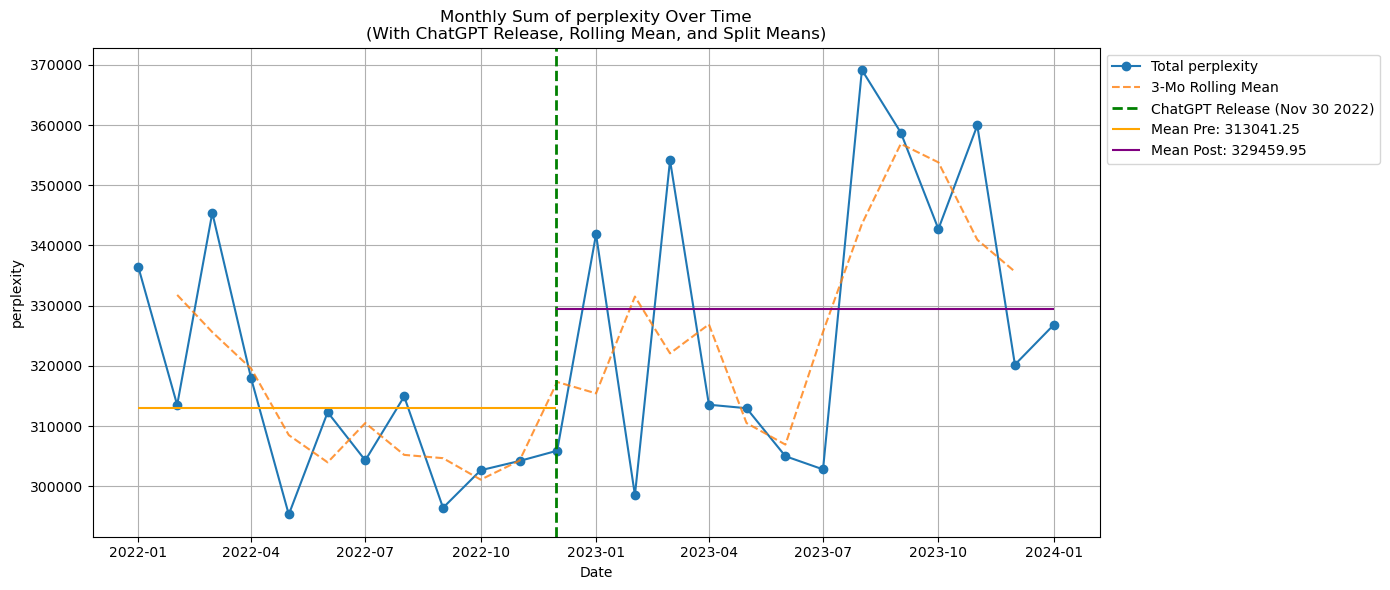

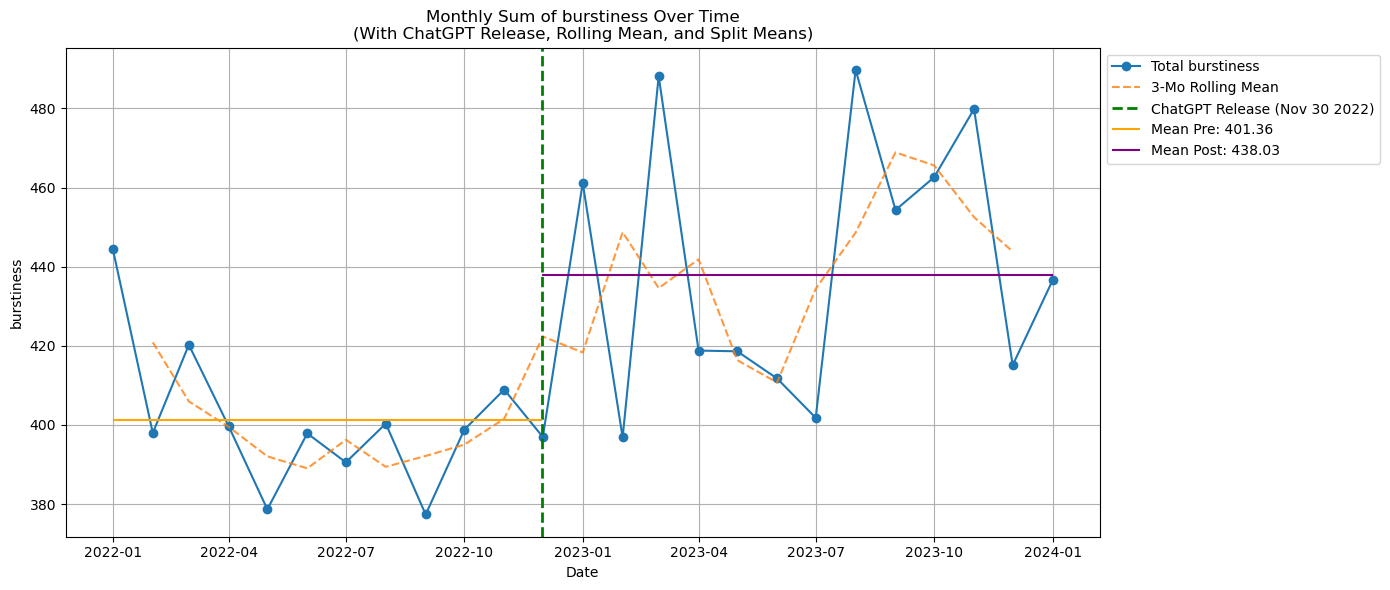

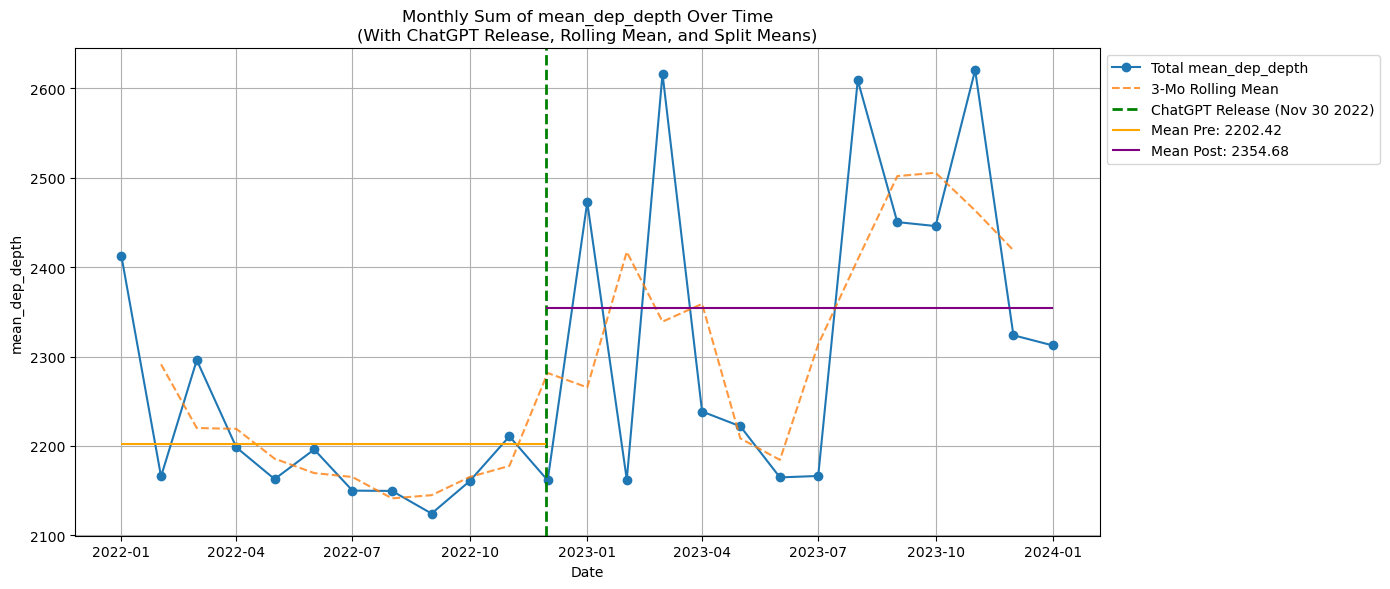

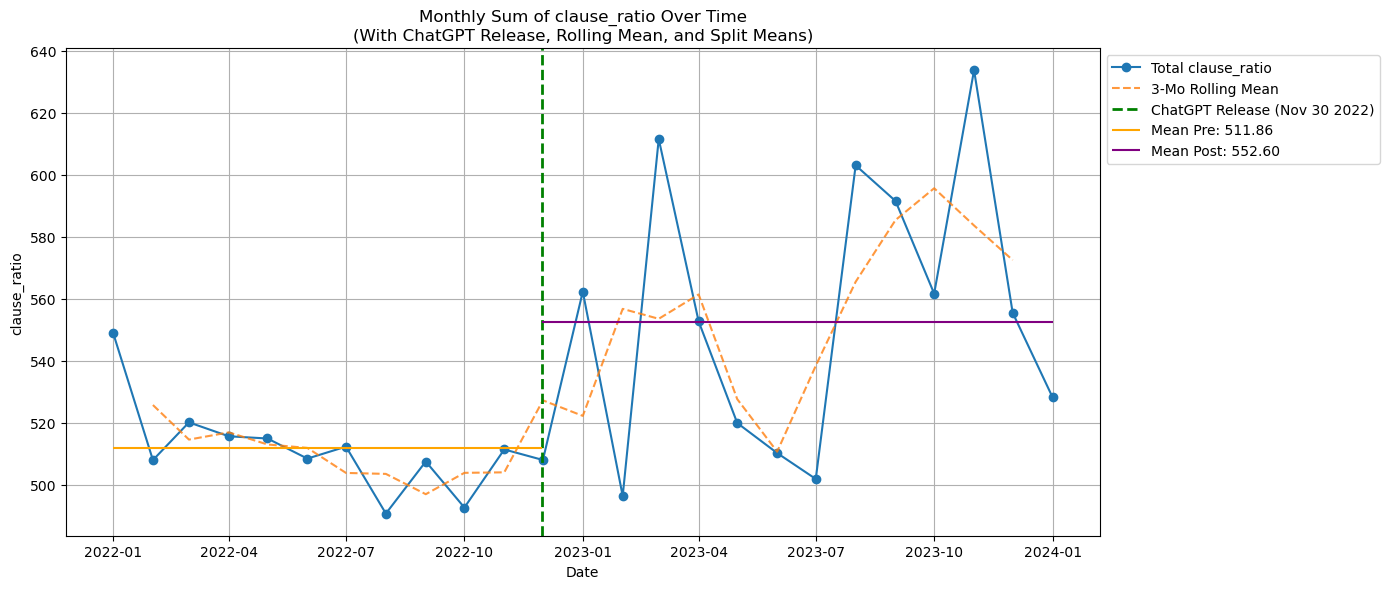

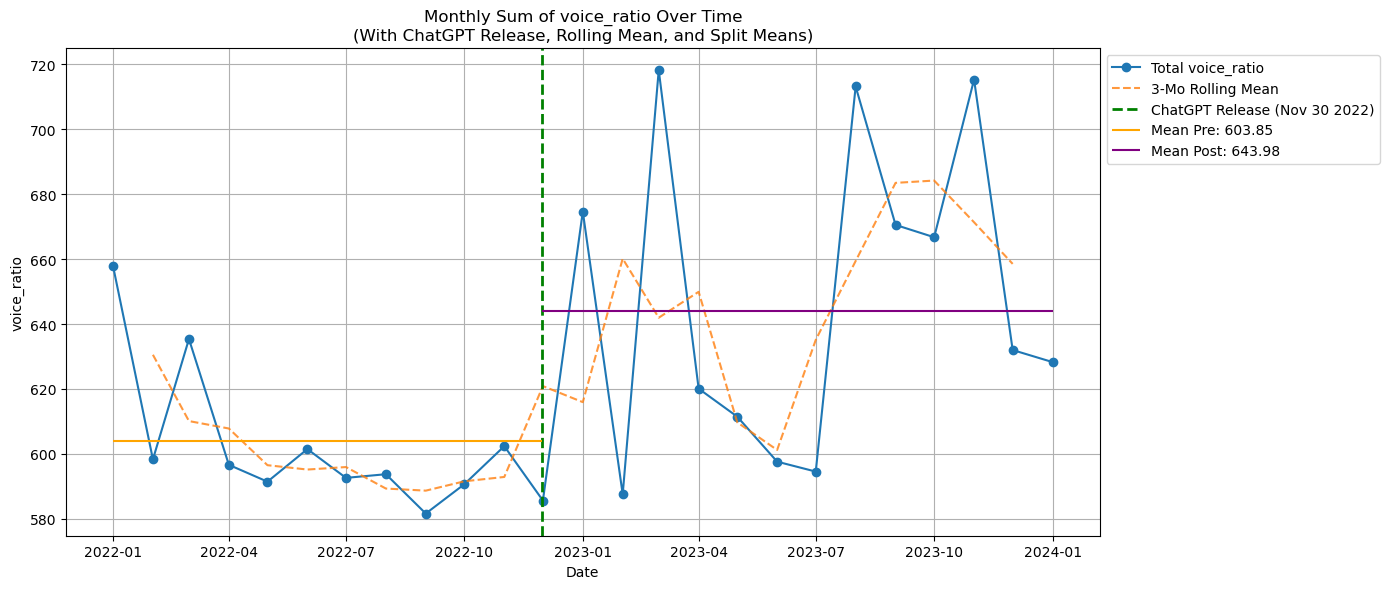

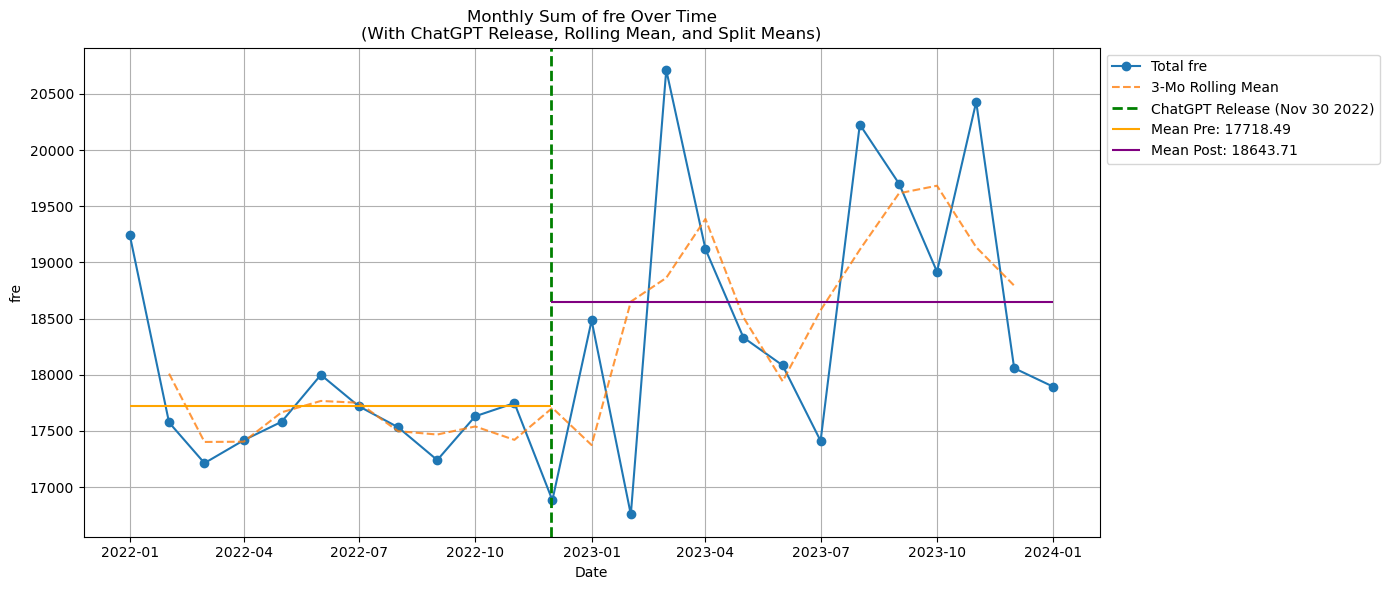

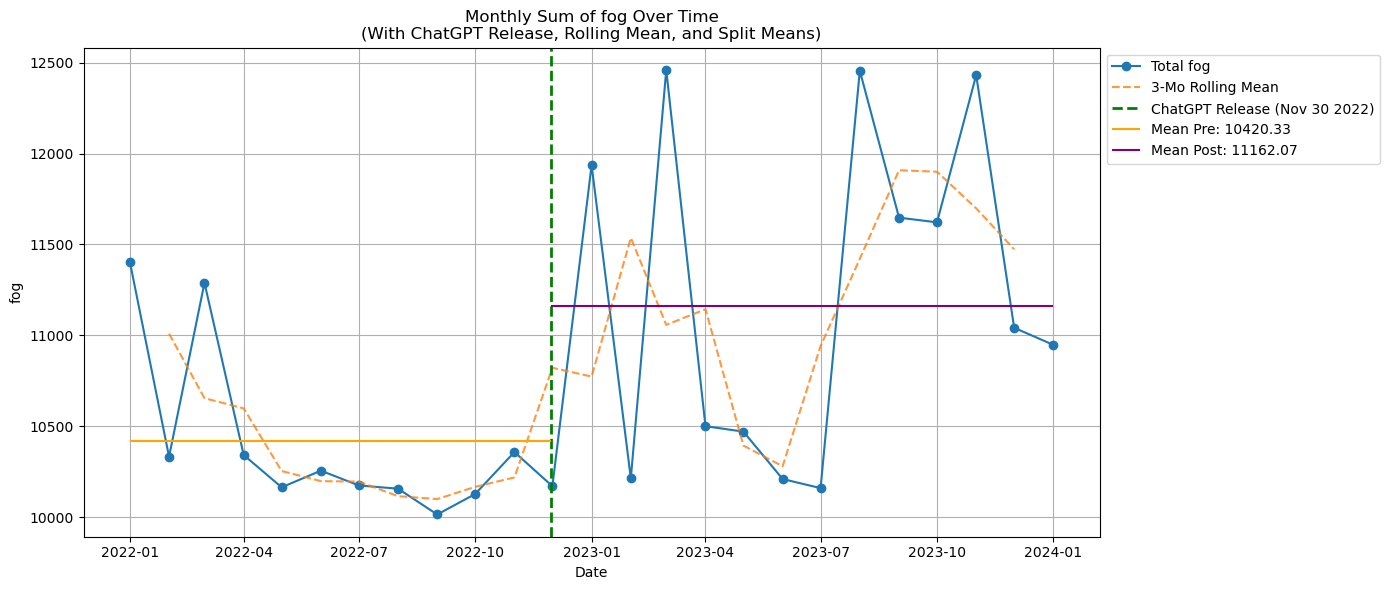

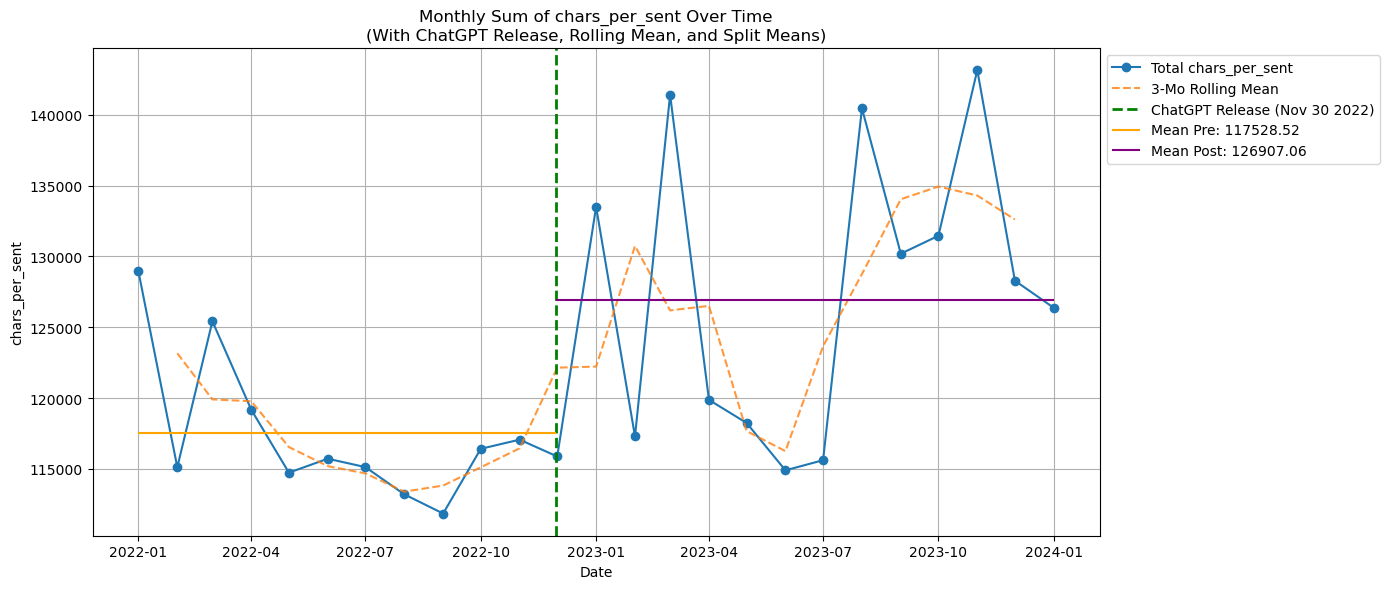

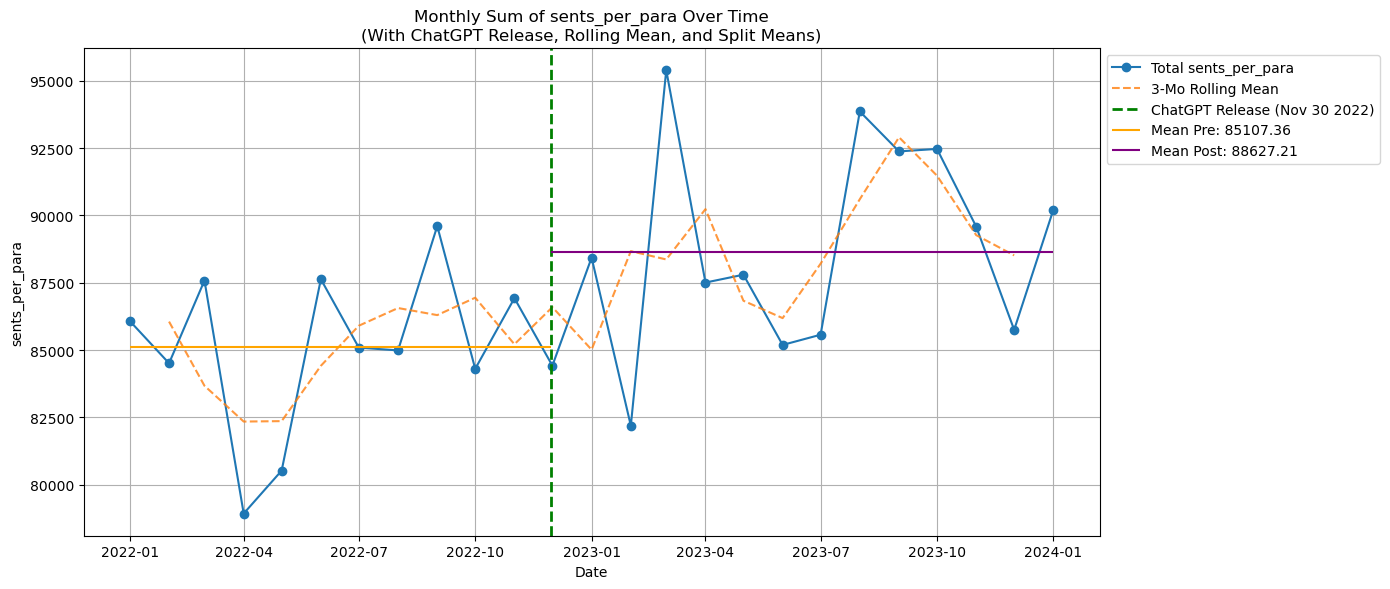

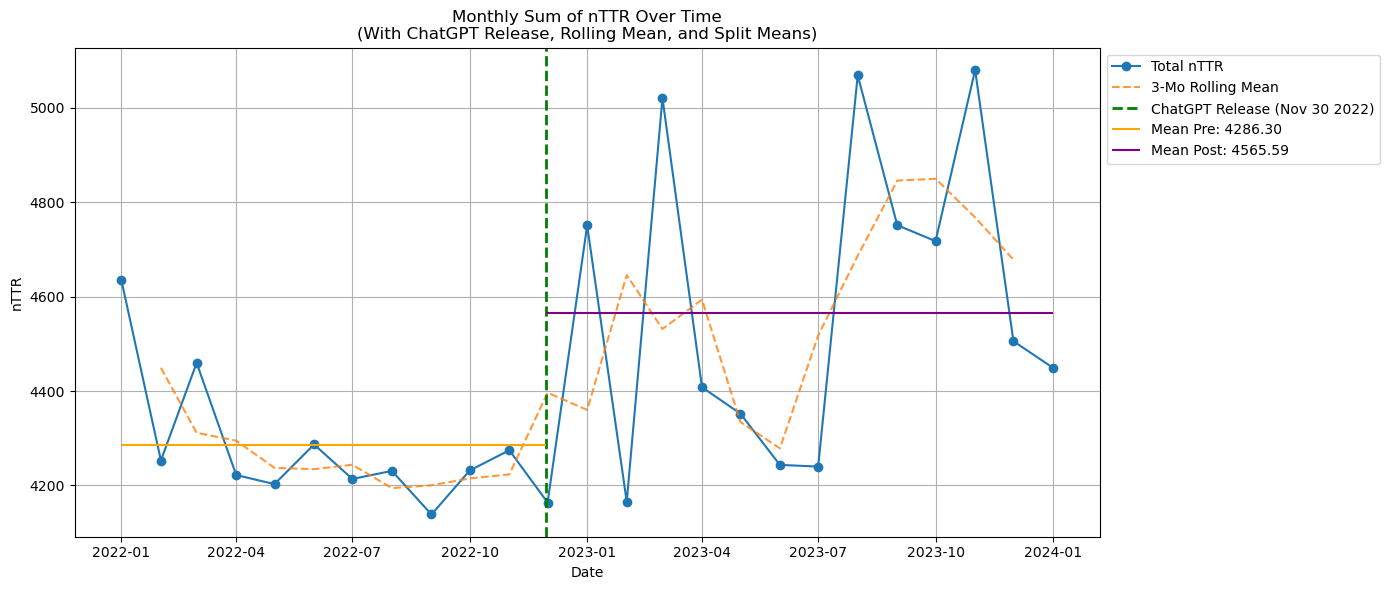

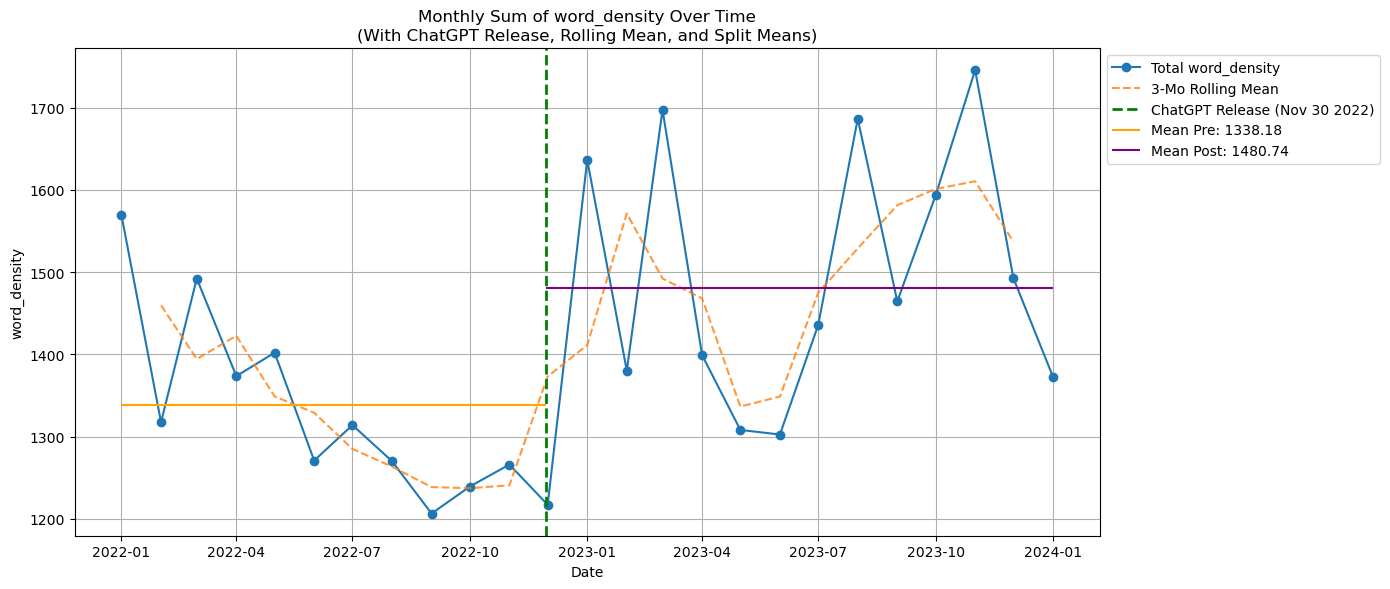

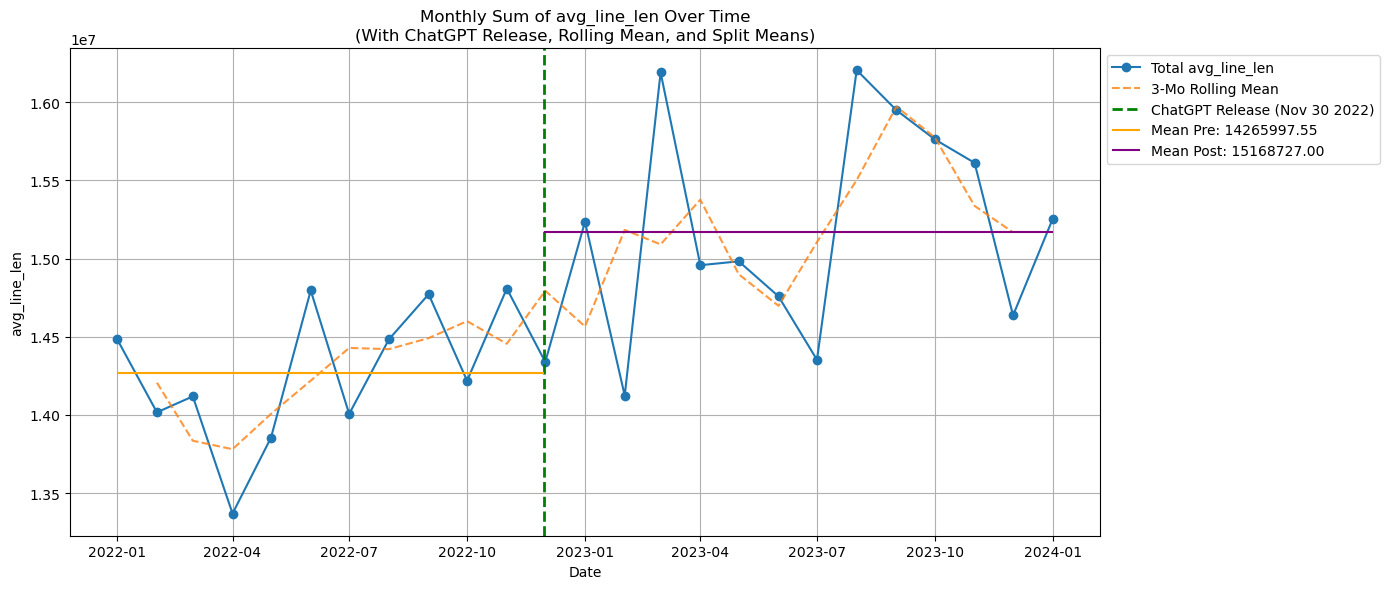

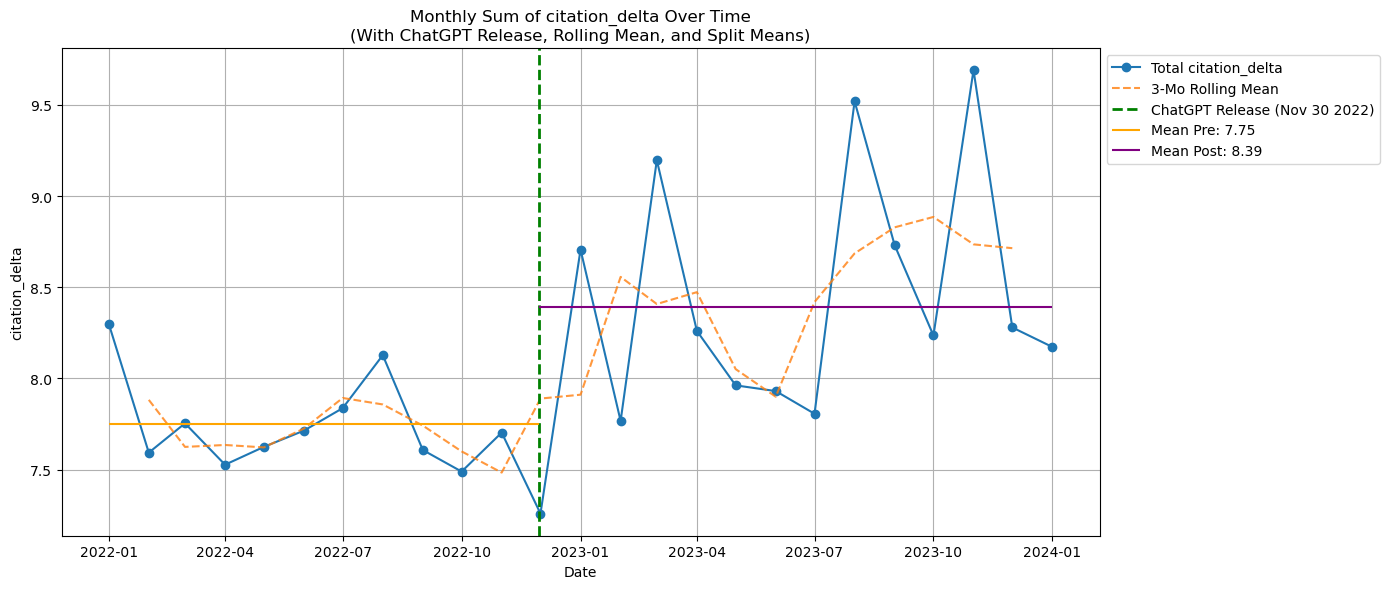

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your revision-level data; must have snapshot_ts + all your delta features
#    e.g. df = pd.read_csv('/mnt/data/final_dataframe.csv', parse_dates=['snapshot_ts'])
#    or  df = pd.read_parquet('/mnt/data/final_dataframe.parquet')
df = pd.read_csv(
    '../python_code/everything100percat.csv',
    parse_dates=['snapshot_ts'],
    date_parser=lambda s: pd.to_datetime(s).tz_convert(None)  # drop tz if present
)

# 2. Drop timezone if any, and bucket into month periods
df['snapshot_ts'] = df['snapshot_ts'].dt.tz_localize(None)
df['month']       = df['snapshot_ts'].dt.to_period('M').dt.to_timestamp()

# 3. Identify your feature columns by excluding metadata
meta_cols = [
    'snapshot_ts','month','rev_id','article_id',
    'user','is_bot','content','title','root','stratum','plain_text'
]
feature_cols = [c for c in df.columns
                if pd.api.types.is_numeric_dtype(df[c]) and c not in meta_cols]

# 4. ChatGPT release date
release = pd.Timestamp('2022-11-30')

# 5. Loop over features
for feat in feature_cols:
    # a) aggregate by month (sum; or .mean() if you prefer average)
    monthly = (
        df.groupby('month')[feat]
          .sum()
          .reset_index(name='value')
    )
    # b) rolling mean
    monthly['rolling'] = monthly['value'].rolling(window=3, center=True).mean()

    # c) pre/post means
    mean_pre  = monthly.loc[monthly['month'] <= release, 'value'].mean()
    mean_post = monthly.loc[monthly['month']  > release, 'value'].mean()

    # d) plot
    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(monthly['month'], monthly['value'],
            marker='o', label=f'Total {feat}')
    ax.plot(monthly['month'], monthly['rolling'],
            linestyle='--', label='3-Mo Rolling Mean', alpha=0.8)

    ax.axvline(release, color='green', linestyle='--', linewidth=2,
               label='ChatGPT Release (Nov 30 2022)')
    ax.hlines(mean_pre,
              xmin=monthly['month'].min(),
              xmax=release,
              colors='orange',
              linestyles='-',
              linewidth=1.5,
              label=f'Mean Pre: {mean_pre:.2f}')
    ax.hlines(mean_post,
              xmin=release,
              xmax=monthly['month'].max(),
              colors='purple',
              linestyles='-',
              linewidth=1.5,
              label=f'Mean Post: {mean_post:.2f}')

    ax.set_title(f'Monthly Sum of {feat} Over Time\n'
                 '(With ChatGPT Release, Rolling Mean, and Split Means)')
    ax.set_xlabel('Date')
    ax.set_ylabel(feat)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.grid(True)
    fig.tight_layout()
    plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_32624\3657701121.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


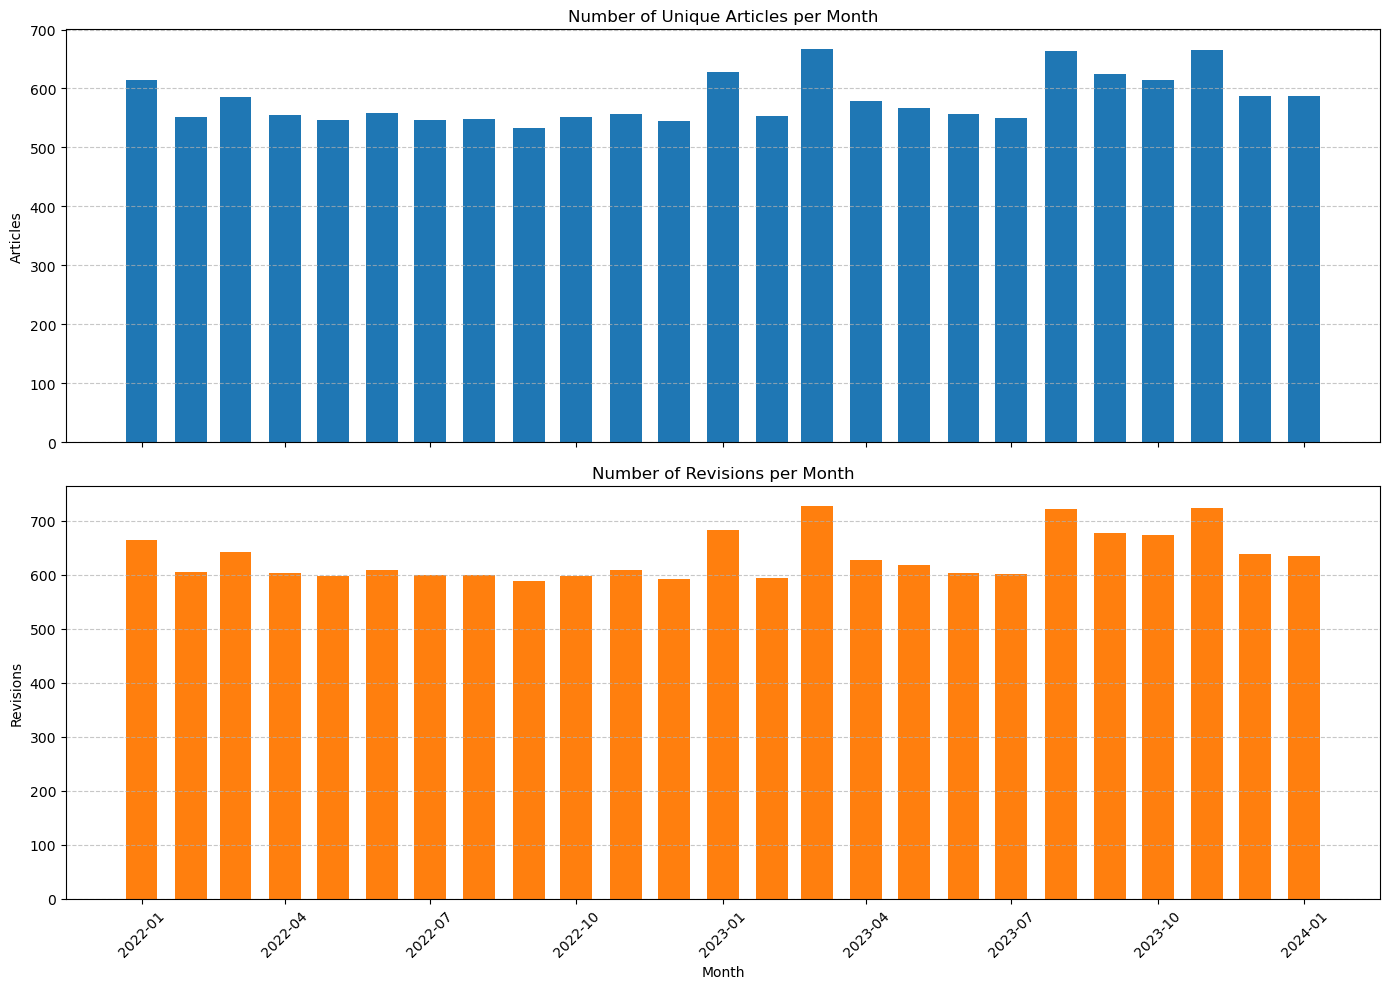

In [30]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv(
    '../python_code/everything100percat.csv',
    parse_dates=['snapshot_ts'],
    date_parser=lambda s: pd.to_datetime(s).tz_convert(None)  # drop tz if present
)

# 2. Drop any timezone and bucket into months
df['snapshot_ts'] = df['snapshot_ts'].dt.tz_localize(None)
df['month']       = df['snapshot_ts'].dt.to_period('M').dt.to_timestamp()

# 3. Aggregate counts
articles_per_month = (
    df.groupby('month')['article_id']
      .nunique()
      .reset_index(name='num_articles')
)

revisions_per_month = (
    df.groupby('month')
      .size()
      .reset_index(name='num_revisions')
)

# 4. Plot side-by-side bar charts
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Unique articles per month
axes[0].bar(
    articles_per_month['month'],
    articles_per_month['num_articles'],
    width=20,
    color='C0'
)
axes[0].set_title('Number of Unique Articles per Month')
axes[0].set_ylabel('Articles')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Revisions per month
axes[1].bar(
    revisions_per_month['month'],
    revisions_per_month['num_revisions'],
    width=20,
    color='C1'
)
axes[1].set_title('Number of Revisions per Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Revisions')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Format x-axis dates
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis_date()

plt.tight_layout()
plt.show()
